### Setup

In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib qt

In [2]:
import os
import sys
from pathlib import Path

In [3]:
src_dir = str(Path(os.getcwd()).parent / "src")
sys.path.insert(1, src_dir)
os.environ["PYTHONPATH"] = src_dir

In [4]:
import data_loader
import calculate_concentr_diffs
from concentr_diffs_pathlength import *
from plotting import *
from mbll_functions import *
from utils import *
from mcs_function import *
from pathlib import Path
import config
import pickle
from ray import tune

import matplotlib.pyplot as plt

In [5]:
config.data_dir

PosixPath('/media/leon/T7/IDP')

In [6]:
config.spectra_dir

PosixPath('/media/leon/Storage/Studium/Informatik/Master/3.Semester/IDP/nonlinear-fit/dataset/UCL-NIR-Spectra/spectra')

Load Data

In [7]:
loader = data_loader.DataLoaderHELICOID(
    config.dataset_dir,
    wavelength_left_cut=520,
    wavelength_right_cut=580
)
delta_A_gt_img = loader.get_attenuation_change("020-01")
A_gt_img = loader.get_attenuation("020-01")

foreground_mask = (loader.label_map != 4) # disgard background
labeled_mask = (loader.label_map != 0)
delta_A_gt_flat = delta_A_gt_img[:, foreground_mask]
A_gt_flat = A_gt_img[:, foreground_mask]

/home/leon/anaconda3/envs/idp/lib/python3.11/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Plot absolute attenuation spectrum at reference_pixel

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


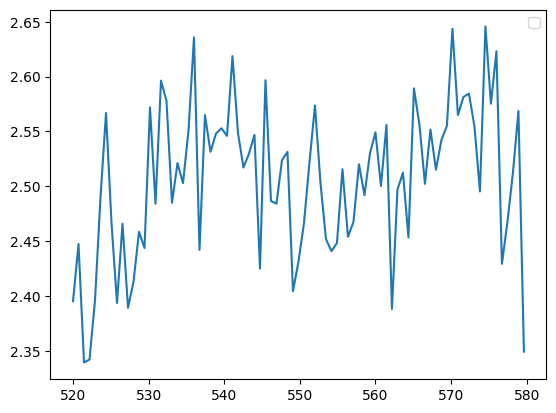

In [8]:
plot_spectrum(A_gt_img[:, loader.reference_pixel[0], loader.reference_pixel[1]], loader.wavelengths)

Load attenuation spectra
Keep in mind, that spectra for water and fat are given for pure solutions, in units of $cm^{-1}$. The "concentrations" for these molecules have to be given as percentages.

In [9]:
mu_a_matrix = loader.absorption_coefs(
    use_diff_oxycco=False,
    use_water_and_fat=True
)

Plot molecule attenuation spectra

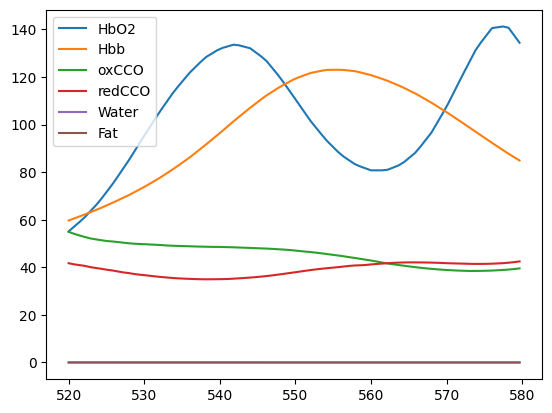

In [10]:
plot_spectra(mu_a_matrix.T, loader.wavelengths, ["HbO2", "Hbb", "oxCCO", "redCCO", "Water", "Fat"])

Plot total attenuation coefficient and scattering for gray matter...

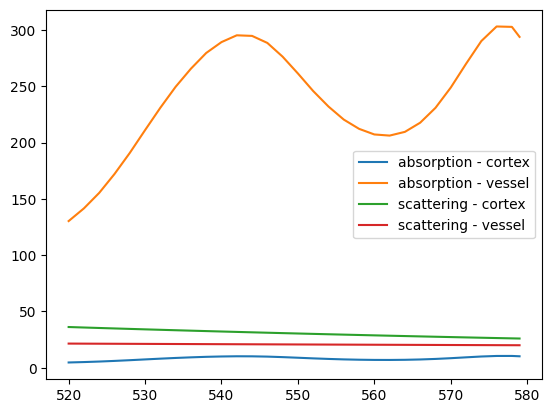

In [11]:
sample_wavelengths = np.arange(520, 580)
plot_spectra(
    (
        loader.mu_a_func_gray_matter(sample_wavelengths),
        loader.mu_a_func_blood_vessel(sample_wavelengths),
        loader.mu_s_red_func_gray_matter(sample_wavelengths),
        loader.mu_s_red_func_blood_vessel(sample_wavelengths)
    ),
    sample_wavelengths,
    ["absorption - cortex", "absorption - vessel", "scattering - cortex", "scattering - vessel"]
)

### Fit MBLL with Pathlengths (for comparison)

Load pathlenghts and interpolate them to used wavelengths

In [12]:
blood_vessel_mcs_data = np.loadtxt(config.pl_dir / "blood_vessel_pure_mcs.txt")
gray_matter_mcs_data = np.loadtxt(config.pl_dir / "gray_matter_mcs.txt")

blood_vessel_pl = np.interp(
    loader.wavelengths,
    blood_vessel_mcs_data[:, 0],
    blood_vessel_mcs_data[:, -1]
)

gray_matter_pl = np.interp(
    loader.wavelengths,
    gray_matter_mcs_data[:, 0],
    gray_matter_mcs_data[:, -1]
)

Compute total pathlength that will be used with MBLL, by dividing attenuation by mu_a

In [13]:
blood_vessel_pl_total = -np.log(blood_vessel_mcs_data[:, 3]) / blood_vessel_mcs_data[:, 1]

gray_matter_pl_total = -np.log(gray_matter_mcs_data[:, 3]) / gray_matter_mcs_data[:, 1]


Plot pathlengths

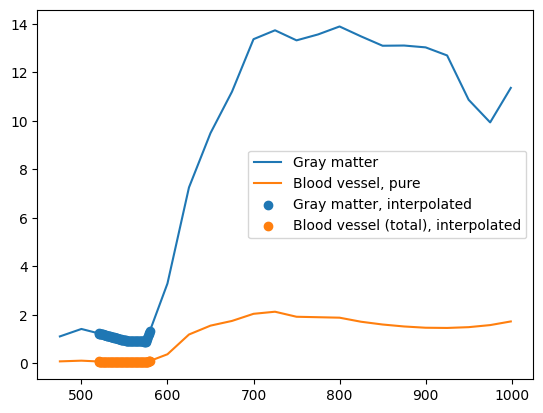

In [14]:
plt.clf()
plt.plot(gray_matter_mcs_data[:, 0], gray_matter_mcs_data[:, -1], label="Gray matter")
plt.plot(blood_vessel_mcs_data[:, 0], blood_vessel_mcs_data[:, -1], label="Blood vessel, pure")
#plt.plot(blood_vessel_mcs_data[:, 0], blood_vessel_mcs_data[:, -2], label="Blood vessel tissue, vessel layer")
#plt.plot(blood_vessel_mcs_data[:, 0], blood_vessel_mcs_data[:, -3], label="Blood vessel tissue, gray matter layer")
#plt.plot(blood_vessel_mcs_data[:, 0], blood_vessel_mcs_data[:, -1], label="Blood vessel, both layers")
plt.scatter(loader.wavelengths, gray_matter_pl, label="Gray matter, interpolated")
plt.scatter(loader.wavelengths, blood_vessel_pl, label="Blood vessel (total), interpolated")
plt.legend()
plt.show()

Build pathlength map

In [ ]:
pl_img = np.empty_like(delta_A_gt_img)
pl_img[:, (loader.label_map <= 2)] = gray_matter_pl_total[:, None]
pl_img[:, (loader.label_map == 3)] = blood_vessel_pl_total[:, None]
pl_flat = pl_img[:, foreground_mask]
pl_flat /= 10 # convert to cm

#### Fit the MBLL model for attenuation change

In [16]:
delta_c_mbll_flat = concentr_fit_mbll(
    delta_A_gt_flat,
    loader.wavelengths,
    mu_a_matrix,
    pl_flat
)

delta_c_mbll_img = np.full((6, *A_gt_img.shape[1:]), np.NaN)
delta_c_mbll_img[:, foreground_mask] = delta_c_mbll_flat

Plot concentrations

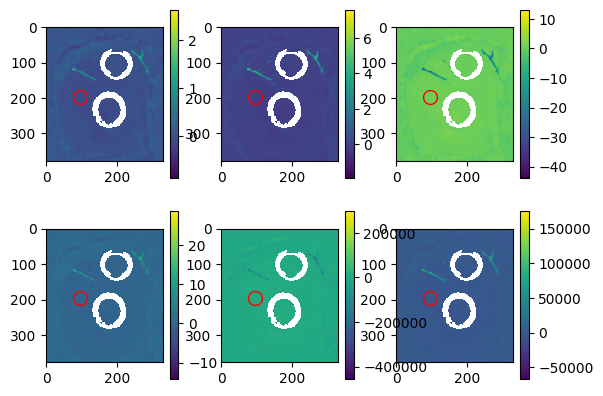

In [17]:
plot_concentration_imgs(delta_c_mbll_img, loader.reference_pixel)

Reconstruct spectra and compare to ground truth

In [18]:
delta_A_reconstr_mbll_flat = mbll_new(loader.wavelengths, mu_a_matrix, delta_c_mbll_flat, pl_flat)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


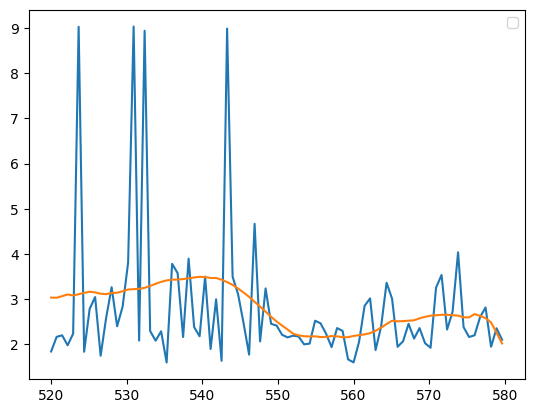

In [19]:
idx = np.random.randint(0, A_gt_flat.shape[1])
plot_spectra((delta_A_gt_flat[:, idx], delta_A_reconstr_mbll_flat[:, idx]), loader.wavelengths)
plt.show()

#### Fit the MBLL model for absolute attenuation

In [20]:
c_mbll_flat = concentr_fit_mbll(
    A_gt_flat,
    loader.wavelengths,
    mu_a_matrix,
    pl_flat
)
c_mbll_img = np.full((6, *A_gt_img.shape[1:]), np.NaN)
c_mbll_img[:, foreground_mask] = c_mbll_flat

Plot concentration images

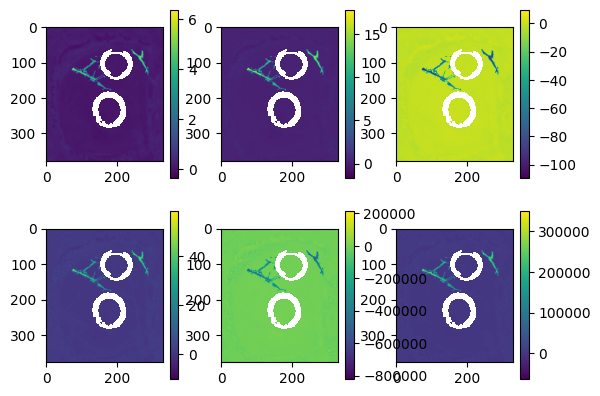

In [21]:
plot_concentration_imgs(c_mbll_img)

### Fit Jacques Model

Load the m-parameters...

In [22]:
with open(config.m_params_path, "rb") as f:
    m_params, A_vals, N_vals, dref_vals = pickle.load(f)

Compare the Pathlength computed by Jacques to the Pathlengths from MCS...

In [23]:
g = 0.85
sample_wavelengths = gray_matter_mcs_data[:, 0]
mu_a_pl_compare = data_loader.DataLoader.mu_a_func_gray_matter(sample_wavelengths) / 10
mu_s_red_pl_compare = data_loader.DataLoader.mu_s_red_func_gray_matter(sample_wavelengths) / 10

In [24]:
m1, m2, m3 = m_params[1.36]
delta = 1 / np.sqrt(3 * mu_a_pl_compare * (mu_a_pl_compare + mu_s_red_pl_compare))
A = (m1 + m2 * np.exp(np.log(mu_s_red_pl_compare / mu_a_pl_compare)/m3))
pl_compare = A * delta 

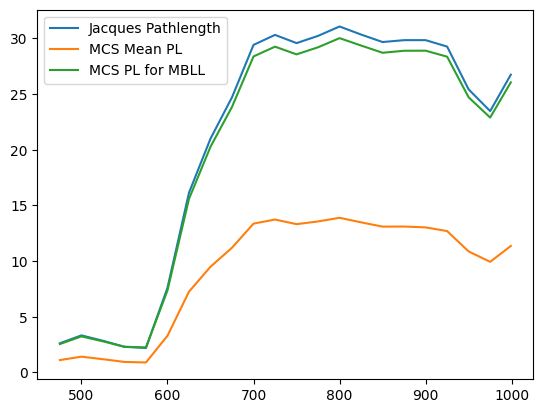

In [25]:
plt.plot(gray_matter_mcs_data[:, 0], pl_compare, label="Jacques Pathlength")
plt.plot(gray_matter_mcs_data[:, 0], gray_matter_mcs_data[:, -1], label="MCS Mean PL")
plt.plot(gray_matter_mcs_data[:, 0], gray_matter_pl_total, label="MCS PL for MBLL")
plt.legend()
plt.show()


In [26]:
pl_compare / gray_matter_mcs_data[:, -1]

array([2.35767468, 2.34719632, 2.38911686, 2.4328363 , 2.45388776,
       2.30673972, 2.22467692, 2.2114711 , 2.20587475, 2.20066949,
       2.20743507, 2.22076804, 2.22866814, 2.23680997, 2.25093751,
       2.26578036, 2.27716785, 2.29051489, 2.30505499, 2.33896179,
       2.36241865, 2.35421828])

Fitting the concentrations for every pixel in the image during hyperparameter search is infeasible, since optimization for one image (i.e. one hyperparameter combination) already takes about 20min. Instead we select all labeled, and a few random unlabeled pixels. Additionally, we make use of the ASHA scheduler, which terminates badly performing trials early.

In [ ]:
# every labeled pixel without background
hyperparameter_search_mask = labeled_mask & foreground_mask
# 500 random unlabeled pixels
hyperparameter_search_mask[np.unravel_index(np.random.choice(np.flatnonzero(~labeled_mask), size=1000, replace=False), labeled_mask.shape)] = True

In [28]:
np.count_nonzero(hyperparameter_search_mask)

1000

Plot the mask...

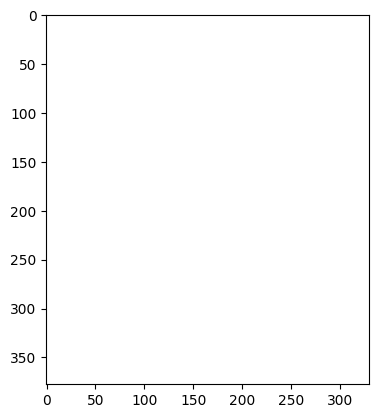

In [29]:

# plotting an rgb image with mask doesn't work for some reason
# hyperparameter_search_img = np.ma.masked_where(np.repeat(~hyperparameter_search_mask[..., None], 3, 2), loader.img)

# convert to grayscale
hyperparameter_search_img = np.dot(loader.img[..., :3], [0.2989, 0.5870, 0.1140])
hyperparameter_search_img[~hyperparameter_search_mask] = np.nan

plt.imshow(hyperparameter_search_img)

#### Fit the Jacques model on attenuation change

In contrast to the MBLL, when using the Jacques model for attenuation change, concentrations are not substracted to form concentration changes. Instead we have to provide absolute concentrations for the reference pixel and the pixel where concentrations are sought. Here, the reference pixel is a pixel of the gray matter area, and its concentrations are treated as hyperparameters. Concentrations of the pixel of interest are optimized using non-linear least-squares.\
For simplicity I assume an average refractive index of 1.38 and use the corresponding values for $m_i$.

In [ ]:
c_ref_gray_matter_fractions = loader.params_ref_gray_matter_fraction[:-2]

param_space = [
    # f_blood
    tune.sample_from(lambda _: min(1, max(0, np.random.normal(c_ref_gray_matter_fractions[0], 0.1)))),
    # st02
    tune.sample_from(lambda _: min(1, max(0, np.random.normal(c_ref_gray_matter_fractions[1], 0.25)))),
    # c_oxCCO
    tune.sample_from(lambda _: max(0, np.random.normal(c_ref_gray_matter_fractions[2], 0.001))),
    # c_redCCO
    tune.sample_from(lambda _: max(0, np.random.normal(c_ref_gray_matter_fractions[3], 0.001))),
    # f_water
    tune.sample_from(lambda config: min(1 - config["0"], max(0, np.random.normal(c_ref_gray_matter_fractions[4], 0.2)))),
    # f_fat
    tune.sample_from(lambda config: min(1 - config["0"] - config["4"], max(0, np.random.normal(c_ref_gray_matter_fractions[5], 0.2)))),
    # a
    tune.sample_from(lambda _: max(3, np.random.normal(loader.params_ref_gray_matter[-2], 10))),
    # b
    tune.sample_from(lambda _: max(0.1, np.random.normal(loader.params_ref_gray_matter[-1], 1))),
    # m1
    m_params[1.38][0],
    # m2
    m_params[1.38][1],
    # m3
    m_params[1.38][2]
]

In [ ]:
# general function that fits a model to data within hyperparameter search
res_grid = concentr_fit_nonlinear_hyperparam_search(
    delta_A_gt_img[:, hyperparameter_search_mask],
    loader.wavelengths,
    mu_a_matrix,
    # the function that is fitted to data
    A_jacques_blood_fraction,
    # parameter space
    param_space=param_space,
    # boolean array indicating which parameters are constant (False) or optimized (True) per pixel
    variables_bool_arr=np.array([True, True, True, True, True, True, True, True, False, False, False]),
    left_bounds=np.array([0, 0, 0, 0, 0, 0, 3, 0.1]),
    right_bounds=np.array([1, 1, 0.01, 0.01, 1, 1, 100, 10]),
    is_delta_A=True, # specify that input data is attenuation change
    # how many spectra are optimized before their average error is reported to ray tune
    # high value -> less overhead due to less reports, but unpromising trials will be killed later
    spectra_per_report=25,
    # how many spectra are checked before trial can be killed
    # will be rounded up to multiple of spectra_per_report
    grace_spectra=50,
    num_samples=500,
    time_budget_s=200
)

In [32]:
score, configuration = None, None

In [ ]:
score, configuration = get_best_values_from_res_grid(res_grid)
print(score)
print(configuration)

Compare to previous config, use and store better ones...

In [33]:
score, configuration = compare_and_update_config(
    score,
    configuration,
    config.result_dir / "jacques_attenuation_change_hyperparams.pickle",
    overwrite_regardless = False
)

Keeping old parameters.


In [ ]:
result_path = config.result_dir / f"jacques_attenuation_change/{loader.patient_id}"
os.makedirs(result_path.parent, exist_ok=True)

Load previous results...

In [ ]:
with open(result_path, "rb") as f:
    params_jacques_delta_A_flat = pickle.load(f)

Run the optimization for the entire image, with the best hyperparameters.

In [ ]:
# general function that fits a model to data
params_jacques_delta_A_flat, errors = concentr_fit_nonlinear(
    delta_A_gt_flat,
    loader.wavelengths,
    mu_a_matrix,
    A_jacques_blood_fraction, # the function that is fitted to data
    # reference values for all variables (concentrations first, then other parameters)
    # f_blood, st02, c_oxCCO, c_redCCO, f_water, f_fat, a (scattering), b (scattering), m1, m2, m3
    ref_vals=configuration,
    #ref_vals = np.concatenate((loader.params_ref_gray_matter, m_params[1.38])),
    # boolean array indicating which variables are constant (False) or optimized (True) per pixel
    variables_bool_arr=np.array([True, True, True, True, True, True, True, True, False, False, False]),
    left_bounds=np.array([0, 0, 0, 0, 0, 0, 3, 0.1, None, None, None]),
    right_bounds=np.array([1, 1, 0.01, 0.01, 1, 1, 100, 10, None, None, None]),
    is_delta_A=True, # specify that input data is attenuation change
    progress_bar=True,
)

Store new results...

In [ ]:
with open(result_path, "wb") as f:
    pickle.dump(params_jacques_delta_A_flat, f)

In [ ]:
# values are already blood fractions
c_jacques_delta_A_flat = params_jacques_delta_A_flat[:6, :]
c_jacques_delta_A_img = np.full((6, *A_gt_img.shape[1:]), np.NaN)
c_jacques_delta_A_img[:, foreground_mask] = c_jacques_delta_A_flat[:6, :] # - config[:6, None]

In [ ]:
plot_concentration_imgs(c_jacques_delta_A_img, loader.reference_pixel)

Compare reconstructed spectra (change) to ground truth spectra.

In [ ]:
delta_A_reconstr_jacques = A_jacques_new(
    loader.wavelengths,
    mu_a_matrix,
    c_jacques_delta_A_flat,
    params_jacques_delta_A_flat[6, :],
    params_jacques_delta_A_flat[7, :],
    *m_params[1.38]
) - A_jacques_blood_fraction(
    loader.wavelengths,
    mu_a_matrix,
    configuration[:6, None],
    *configuration[6:]
)

In [ ]:
idx = np.random.randint(0, A_gt_flat.shape[1])
plot_spectra((delta_A_gt_flat[:, idx], delta_A_reconstr_jacques[:, idx]), loader.wavelengths)
plt.show()

Check if concurrent computation delivers same results as sequential optimization. Slight differences can occur, because concurrent processes cannot initialize NLLS for the first spectrum of their chunks with the results of the previous spectrum (since this is part of another process). To avoid this factor during comparison, both optimizations are instructed (update_init=False) to initialize every NLLS with the values of ref_vals.

In [34]:
# general function that fits a model to data
params_jacques_delta_A_flat_sequential, errors = concentr_fit_nonlinear(
    delta_A_gt_img[:, hyperparameter_search_mask],
    loader.wavelengths,
    mu_a_matrix,
    A_jacques_blood_fraction, # the function that is fitted to data
    # reference values for all variables (concentrations first, then other parameters)
    # f_blood, st02, c_oxCCO, c_redCCO, f_water, f_fat, a (scattering), b (scattering), m1, m2, m3
    ref_vals=configuration,
    #ref_vals = np.concatenate((loader.params_ref_gray_matter, m_params[1.38])),
    # boolean array indicating which variables are constant (False) or optimized (True) per pixel
    variables_bool_arr=np.array([True, True, True, True, True, True, True, True, False, False, False]),
    left_bounds=np.array([0, 0, 0, 0, 0, 0, 3, 0.1, None, None, None]),
    right_bounds=np.array([1, 1, 0.01, 0.01, 1, 1, 100, 10, None, None, None]),
    is_delta_A=True, # specify that input data is attenuation change
    progress_bar=True,
    update_init=False
)

Note: Bounds for parameters 8, 9, 10 will be ignored, as they are not optimized.
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
2

In [35]:
# general function that fits a model to data
params_jacques_delta_A_flat_concurrent, errors = concentr_fit_nonlinear_concurrent(
    delta_A_gt_img[:, hyperparameter_search_mask],
    loader.wavelengths,
    mu_a_matrix,
    A_jacques_blood_fraction, # the function that is fitted to data
    # reference values for all variables (concentrations first, then other parameters)
    # f_blood, st02, c_oxCCO, c_redCCO, f_water, f_fat, a (scattering), b (scattering), m1, m2, m3
    ref_vals=configuration,
    #ref_vals = np.concatenate((loader.params_ref_gray_matter, m_params[1.38])),
    # boolean array indicating which variables are constant (False) or optimized (True) per pixel
    variables_bool_arr=np.array([True, True, True, True, True, True, True, True, False, False, False]),
    left_bounds=np.array([0, 0, 0, 0, 0, 0, 3, 0.1, None, None, None]),
    right_bounds=np.array([1, 1, 0.01, 0.01, 1, 1, 100, 10, None, None, None]),
    is_delta_A=True, # specify that input data is attenuation change
    update_init=False,
    num_processes=6
)

Note: Bounds for parameters 8, 9, 10 will be ignored, as they are not optimized.Note: Bounds for parameters 8, 9, 10 will be ignored, as they are not optimized.Note: Bounds for parameters 8, 9, 10 will be ignored, as they are not optimized.Note: Bounds for parameters 8, 9, 10 will be ignored, as they are not optimized.Note: Bounds for parameters 8, 9, 10 will be ignored, as they are not optimized.Note: Bounds for parameters 8, 9, 10 will be ignored, as they are not optimized.





Process 0/6 finished.
Process 1/6 finished.
Process 2/6 finished.
Process 3/6 finished.
Process 4/6 finished.
Process 5/6 finished.


In [36]:
diff = np.abs(params_jacques_delta_A_flat_concurrent - params_jacques_delta_A_flat_sequential)

In [37]:
np.allclose(diff, 0)

True

In [ ]:
plt.imshow(diff, cmap='hot', interpolation='nearest', aspect="auto")
plt.colorbar()
plt.show()

#### Fit Jacques on Absolute Attenuation

Here, we fit the Jacques model directly against absolute attenuation spectra. The reference values will only serve as an initialization for non-linear least squares for the first pixel. Therefore it should be reasonable to use reference values for gray matter. Subsequent pixels will be initialized with the result of their preceeding pixel.

In [ ]:
result_path = config.result_dir / f"jacques_attenuation_absolute/{loader.patient_id}"
os.makedirs(result_path.parent, exist_ok=True)

Load previous results...

In [ ]:
with open(result_path, "rb") as f:
    params_jacques_flat = pickle.load(f)

In [ ]:
params_jacques_flat, errors = concentr_fit_nonlinear(
    A_gt_flat,
    loader.wavelengths,
    mu_a_matrix,
    A_jacques_blood_fraction,
    ref_vals=np.concatenate((loader.params_ref_gray_matter_fraction, m_params[1.38])),
    variables_bool_arr=np.array([True, True, True, True, True, True, True, True, False, False, False]),
    left_bounds=np.array([0, 0, 0, 0, 0, 0, 3, 0.1, None, None, None]),
    right_bounds=np.array([1, 1, 0.04, 0.04, 1, 1, 100, 10, None, None, None]),
    is_delta_A=False,
    progress_bar=True
)

Store new results...

In [ ]:
with open(result_path, "wb") as f:
    pickle.dump(params_jacques_flat, f)

In [ ]:
c_jacques_flat = blood_fraction_to_concentrations(params_jacques_flat[:6, :])
c_jacques_img = np.full((6, *A_gt_img.shape[1:]), np.NaN)
c_jacques_img[:, foreground_mask] = params_jacques_flat[:6, :]

In [ ]:
plot_concentration_imgs(c_jacques_img)

#### Fit Jacques on Absolute Attenuation, constrain volume fractions

Up until now, we only bounded the individual volume fraction of a molecule to be within $[0, 1]$, and the molar concentrations to be greater than 0. We can also add the constraint, that the sum of volume fractions is within $[0, 1]$. In this case, we can no longer optimize using a non-linear least squares solver like Levenberg Marquardt. As a result the optimization takes about 60x as long as without constraints.

In [ ]:
result_path = config.result_dir / f"jacques_attenuation_absolute_constrained/{loader.patient_id}"
os.makedirs(result_path.parent, exist_ok=True)

Load previous results...

In [ ]:
with open(result_path, "rb") as f:
    params_jacques_constrained_flat = pickle.load(f)

In [ ]:
params_jacques_constrained_flat, errors = concentr_fit_nonlinear(
    A_gt_img[:, foreground_mask & labeled_mask],
    loader.wavelengths,
    mu_a_matrix,
    A_jacques_blood_fraction,
    ref_vals=np.concatenate((c_ref_gray_matter_fractions, [40.8, 3.089], m_params[1.38])),
    variables_bool_arr=np.array([True, True, True, True, True, True, True, True, False, False, False]),
    left_bounds=np.array([0, 0, 0, 0, 0, 0, 3, 0.1, None, None, None]),
    right_bounds=np.array([1, 1, 0.4, 0.4, 1, 1, 100, 10, None, None, None]),
    is_delta_A=False,
    # linear constraint given as (A (matrix), lb (vector), ub (vector))
    # parameter vector x should satisfy
    # lb <= A @ x <= ub
    constraint=(np.array([[1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]]), np.array([0]), np.array([1])),
    progress_bar=True
)

Store new results...

In [ ]:
with open(result_path, "wb") as f:
    pickle.dump(params_jacques_flat, f)

In [ ]:
c_jacques_constrained_flat = blood_fraction_to_concentrations(params_jacques_constrained_flat[:6, :])
c_jacques_constrained_img = np.full((6, *A_gt_img.shape[1:]), np.NaN)
c_jacques_constrained_img[:, foreground_mask & labeled_mask] = c_jacques_constrained_flat

In [ ]:
plot_concentration_imgs(c_jacques_constrained_img)

#### Fit Jacques on Absolute Attenuation spectra, with constant scattering, for blood region seprately

Here we again fit the Jacques model to absolute attenuation spectra but assume constant scattering in blood vessel, and non-blood vessel areas. Here we can also take different $m_i$'s into account.

In [ ]:
result_path = config.result_dir / f"jacques_attenuation_absolute_const_scatter/{loader.patient_id}"
os.makedirs(result_path.parent, exist_ok=True)

Load previous results...

In [ ]:
with open(result_path, "rb") as f:
    c_jacques_blood_vessel_flat, c_jacques_gray_matter_flat = pickle.load(f)

In [ ]:
c_jacques_blood_vessel_flat, errors = concentr_fit_nonlinear(
    A_gt_img[:, (loader.label_map == 3)],
    loader.wavelengths,
    mu_a_matrix,
    A_jacques_blood_fraction,
    ref_vals=np.concatenate((loader.params_ref_blood_vessel_fraction, m_params[1.4])),
    variables_bool_arr=np.array([True, True, True, True, True, True, False, False, False, False, False]),
    left_bounds=np.array([0, 0, 0, 0, 0, 0, 0.5, 0.01, None, None, None]),
    right_bounds=np.array([1, 1, 0.04, 0.04, 1, 1, 100, 10, None, None, None])
)

In [ ]:
c_jacques_gray_matter_flat, errors = concentr_fit_nonlinear(
    A_gt_img[:, (loader.label_map <= 2)],
    loader.wavelengths,
    mu_a_matrix,
    A_jacques_blood_fraction,
    ref_vals=np.concatenate((loader.params_ref_gray_matter_fraction, m_params[1.38])),
    variables_bool_arr=np.array([True, True, True, True, True, True, False, False, False, False, False]),
    left_bounds=np.array([0, 0, 0, 0, 0, 0, 3, 0.1, None, None, None]),
    right_bounds=np.array([1, 1, 0.04, 0.04, 1, 1, 100, 10, None, None, None]),
    is_delta_A=False,
    progress_bar=True
)

Store new results...

In [ ]:
with open(result_path, "wb") as f:
    pickle.dump((c_jacques_blood_vessel_flat, c_jacques_gray_matter_flat), f)

In [ ]:
c_jacques_blood_vessel_flat = blood_fraction_to_concentrations(c_jacques_blood_vessel_flat)
c_jacques_gray_matter_flat = blood_fraction_to_concentrations(c_jacques_gray_matter_flat)
c_jacques_const_scatter_img = np.full((6, *A_gt_img.shape[1:]), np.NaN)
c_jacques_const_scatter_img[:, (loader.label_map == 3)] = c_jacques_blood_vessel_flat
c_jacques_const_scatter_img[:, (loader.label_map <= 2)] = c_jacques_gray_matter_flat

In [ ]:
plot_concentration_imgs(c_jacques_const_scatter_img)

We can also see how the (absolute) ground truth spectra compare to the reconstructed spectra.

In [ ]:
A_reconstr_jacques_const_scatter_img = np.empty_like(A_gt_img)
A_reconstr_jacques_const_scatter_img[:, (loader.label_map == 3)] = A_jacques_new(
    loader.wavelengths,
    mu_a_matrix,
    c_jacques_blood_vessel_flat,
    22.0,
    0.660,
    *m_params[1.4]
)
A_reconstr_jacques_const_scatter_img[:, (loader.label_map <= 2)] = A_jacques_new(
    loader.wavelengths,
    mu_a_matrix,
    c_jacques_gray_matter_flat,
    40.8,
    3.089,
    *m_params[1.4]
)
A_reconstr_jacques_const_scatter_flat = A_reconstr_jacques_const_scatter_img[:, foreground_mask]

In [ ]:
idx = np.random.randint(0, A_gt_flat.shape[1])
plot_spectra((A_gt_flat[:, idx], A_reconstr_jacques_const_scatter_flat[:, idx]), loader.wavelengths)
plt.show()

# Fit the model from Monte Carlo Simulations

In [39]:
mcs_obj = SimulationAttenuation(config.mcs_func_path)

Loaded data with 100000.0 photons and 26 values for mu_s.


In [40]:
loader_mcs = data_loader.DataLoaderHELICOID(
    config.dataset_dir,
    wavelength_left_cut=520,
    wavelength_right_cut=850,
    num_wavelengths=10
)
delta_A_gt_mcs_img = loader_mcs.get_attenuation_change("020-01")
A_gt_mcs_img = loader_mcs.get_attenuation("020-01")

mu_a_matrix_mcs = loader_mcs.absorption_coefs(
    use_diff_oxycco=False,
    use_water_and_fat=True
)

In [41]:
loader_mcs.wavelengths

array([520.        , 556.36363636, 592.72727273, 629.81818182,
       666.18181818, 702.54545455, 738.90909091, 776.        ,
       812.36363636, 848.72727273])

In [42]:
A_gt_mcs_img[:, foreground_mask & labeled_mask].shape

(10, 7010)

### Fit the MC model on absolute attenuation

In [46]:
result_path = config.result_dir / f"mcs_attenuation_absolute/{loader_mcs.patient_id}"
os.makedirs(result_path.parent, exist_ok=True)

Load previous results...

In [ ]:
with open(result_path, "rb") as f:
    params_mcs_flat = pickle.load(f)

In [ ]:
params_mcs_flat, errors = concentr_fit_nonlinear_concurrent(
    A_gt_mcs_flat,
    loader_mcs.wavelengths,
    mu_a_matrix_mcs,
    mcs_obj.A_blood_fraction,
    jacobian=mcs_obj.jacobian_blood_fraction,
    ref_vals=blood_fraction_to_concentrations(loader_mcs.params_ref_gray_matter),
    variables_bool_arr=np.array([True, True, True, True, True, True, True, True]),
    left_bounds=np.array([0, 0, 0, 0, 0, 0, 3, 0.1]),
    right_bounds=np.array([1, 1, 0.04, 0.04, 1, 1, 100, 10]),
    is_delta_A=False,
    progress_bar=True,
    num_processes=6
)

/media/leon/Storage/Studium/Informatik/Master/3.Semester/IDP/nonlinear-fit/src/mcs_function.py:77: RuntimeWarning: invalid value encountered in multiply
  weighted_pl_lower = np.sum(np.nan_to_num(weights_lower * self.photon_data[mu_s_upper_idxs - 1, 0, :]), axis=-1) / total_weights_lower
/media/leon/Storage/Studium/Informatik/Master/3.Semester/IDP/nonlinear-fit/src/mcs_function.py:77: RuntimeWarning: invalid value encountered in multiply
  weighted_pl_lower = np.sum(np.nan_to_num(weights_lower * self.photon_data[mu_s_upper_idxs - 1, 0, :]), axis=-1) / total_weights_lower
/media/leon/Storage/Studium/Informatik/Master/3.Semester/IDP/nonlinear-fit/src/mcs_function.py:77: RuntimeWarning: invalid value encountered in multiply
  weighted_pl_lower = np.sum(np.nan_to_num(weights_lower * self.photon_data[mu_s_upper_idxs - 1, 0, :]), axis=-1) / total_weights_lower
/media/leon/Storage/Studium/Informatik/Master/3.Semester/IDP/nonlinear-fit/src/mcs_function.py:77: RuntimeWarning: invalid value enco

0


/media/leon/Storage/Studium/Informatik/Master/3.Semester/IDP/nonlinear-fit/src/mcs_function.py:77: RuntimeWarning: invalid value encountered in multiply
  weighted_pl_lower = np.sum(np.nan_to_num(weights_lower * self.photon_data[mu_s_upper_idxs - 1, 0, :]), axis=-1) / total_weights_lower


0
0


/media/leon/Storage/Studium/Informatik/Master/3.Semester/IDP/nonlinear-fit/src/mcs_function.py:77: RuntimeWarning: invalid value encountered in multiply
  weighted_pl_lower = np.sum(np.nan_to_num(weights_lower * self.photon_data[mu_s_upper_idxs - 1, 0, :]), axis=-1) / total_weights_lower


0
1
0
1
1
0
1
2
1
2
1
2
2
3
2
2
3
3
3
4
3
4
3
4
4
4
5
5
5
4
5
5
6
6
6
5
6
6
7
7
7
6
7
7
8
8
8
7
8
8
9
9
9
8
9
9
10
10
10
9
10
10
11
11
11
10
11
11
12
12
12
11
12
12
13
13
13
12
13
13
14
14
14
13
14
14
15
15
15
14
15
15
16
16
16
15
16
17
16
17
16
17
17
17
18
18
18
17
19
18
18
19
19
18
1920

19
20
20
19
20
21
20
21
20
21
21
22
21
21
22
22
23
22
22
22
2423

23
23
23
23
24
24
25
24
24
24
25
25
25
26
25
26
25
26
2726

26
27
2728

2627

27
29
28
27
28
28
30
28
29
29
28
29
31
29
30
30
32
29
30
30
31
33
31
30
31
31
34
32
32
31
35
32
32
33
33
36
32
33
33
34
37
34
34
33
34
35
38
35
34
35
35
36
39
35
36
36
36
3740

36
37
37
37
37
41
38
38
38
38
38
42
39
39
39
39
3943

40
40
40
40
40
44
41
41
41
41
45
41
42
42
42
42
46
43
42
43
43
47
43
44
43
44
44
48
45
44
44
45
45
49
46
45
46
4546

50
47
47
46
46
51
47
4848

4748

47
52
49
48
49
49
53
48
50
49
54
50
49
50
51
5550

51
50
51
52
51
56
52
52
51
53
53
57
52
53
52
54
58
5453

54
53
55
54
59
55
55
54
56
60
55
56
56
55
57
61
56
57
57
58
56
62
57
5858

5

Store new results...

In [47]:
with open(result_path, "wb") as f:
    pickle.dump(params_mcs_flat, f)

In [48]:
c_mcs_flat = blood_fraction_to_concentrations(params_mcs_flat[:6, :])
c_mcs_img = np.full((6, *A_gt_img.shape[1:]), np.NaN)
c_mcs_img[:, foreground_mask & labeled_mask] = c_mcs_flat[:6, :]

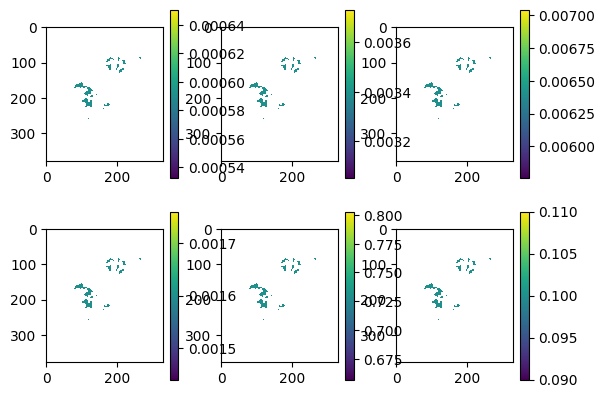

In [49]:
plot_concentration_imgs(c_mcs_img)